# Visual Relationship Recognition Convolutional Neural Network

## Imports

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
sys.path.append("../Mask_RCNN-master/")
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG16

from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.__version__

'1.15.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data

### [Open Images Dataset V5](https://storage.googleapis.com/openimages/web/challenge.html)


Image Net compressed data (52Gb): [https://drive.google.com/uc?id=10yVowvmFjMkY21-DGF2pej_Lbecfqou7](https://drive.google.com/uc?id=10yVowvmFjMkY21-DGF2pej_Lbecfqou7)  ([Info](https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770))


In [5]:
IMAGE_DIR = r"D:\data\train-256\train"
DATA_OUTPUT_DIR = r"D:\data\VRNet"

In [6]:
DEPTH = 9
LAYER_TYPE = 'LSTM' # 'GRU'

***

***

In [7]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path).convert('RGB')

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

## Transfer

In [8]:
from tensorflow.keras.applications import \
    VGG16, VGG19, InceptionV3, ResNet50, ResNet101, NASNetLarge, MobileNetV2

image_model = MobileNetV2(include_top=True, weights='imagenet')
IMAGE_MODEL_NAME = image_model.name

W0227 19:20:35.999152 18160 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


https://github.com/matterport/Mask_RCNN/releases

In [9]:
image_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
# transfer_layer = image_model.get_layer('fc2')
transfer_layer = image_model.layers[-2]

In [11]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [12]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [13]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

1280

#### Process All Images

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [14]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%} {1}/{2}".format(pct_complete, count, max_count)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [15]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
        
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            #try: 
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img
            #except: 
            # print(f"\nFaulty image: {i, filename}")
            # removal_list.append(filename)
            # os.remove(filename)
            # faulty_imgs.append(filename)

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    
    #import pickle
    #removal_list_file = "to_remove.pkl"
    #with open(removal_list_file, 'wb') as f:
    #    pickle.dump(removal_list, f)
    
    # Print newline.
    print()

    return transfer_values

In [16]:
def process_images_train(filenames_array, output_fn):
    print("Processing {0} images in training-set ...".format(len(filenames_array)))

    # Path for the cache-file.
    cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"transfer_values_{output_fn}.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=IMAGE_DIR,
                            filenames=filenames_array)

    return transfer_values

***

## Augmentation

# Tokenization

***

***

In [17]:
IMAGE_DIR_REL = r"D:\data\VRNet\imagenet_rel_subset"

In [18]:
all_relationships_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-train-vrd.csv"
all_relationships = pd.read_csv(all_relationships_file)
all_relationships.describe()

,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2
count,374768.000000,374768.000000,374768.000000,374768.000000,374768.000000,374768.000000,374768.000000,374768.000000
mean,0.373899,0.624713,0.426304,0.785764,0.333565,0.666269,0.500565,0.807825
std,0.267712,0.267785,0.219537,0.206131,0.264643,0.265483,0.197521,0.203616
min,0.000000,0.002930,0.000000,0.013542,0.000000,0.002930,0.000000,0.013542
25%,0.136875,0.409944,0.262500,0.642222,0.097000,0.462313,0.388980,0.670732
50%,0.355000,0.642500,0.442653,0.830833,0.295625,0.704102,0.522222,0.872045
75%,0.588750,0.861875,0.589286,0.983333,0.534729,0.905582,0.636023,0.995028
max,0.999375,2.055000,0.996248,1.196667,0.999375,2.055000,0.996248,1.196667


In [19]:
rel_definition_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-relationship-triplets.csv"
rel_definition = pd.read_csv(rel_definition_file)
rel_definition.describe()

,LabelName1,LabelName2,RelationshipLabel
count,329,329,329
unique,32,58,10
top,/m/04yx4,/m/04bcr3,holds
freq,63,18,108


In [20]:
rel_counts = all_relationships.ImageID.value_counts()
rel_counts

ab4f5a8a2f533316    474
bca2e0ee12378c67    168
640a5f71e5aed9e8    145
27bb93c740ae1fe3    145
05b0aefc92880a6c    138
                   ... 
da80cd3255047b7e      1
42293014762e5fa8      1
027111b62a658f06      1
f83fa39b4b527df8      1
4578aad42ca9a289      1
Name: ImageID, Length: 100522, dtype: int64

## Remove is relations:----

In [21]:
# Do not use 'is' relationships
all_relationships_non_is = all_relationships[all_relationships.RelationshipLabel != "is"]
len(all_relationships_non_is)

180626

In [22]:
images_w_relationships = all_relationships_non_is.ImageID.unique()
len(images_w_relationships)

57187

In [23]:
images_w_relationships_paths = [os.path.join(IMAGE_DIR_REL, (f + '.jpg')) for f in images_w_relationships]
len(images_w_relationships_paths)

57187

In [24]:
imageIDs_trainz = images_w_relationships

In [25]:
# Some images don't work
# imageIDs_trainz = imageIDs_trainz[imageIDs_trainz!=("5f07cc69123be854")]

In [26]:
filenames_trainz = [os.path.join(IMAGE_DIR_REL, (f + '.jpg')) for f in imageIDs_trainz]
len(filenames_trainz)

57187

***

In [27]:
%%time
transfer_values_train = process_images_train(filenames_trainz, f"{image_model.name}")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 57187 images in training-set ...
- Data loaded from cache-file: D:\data\VRNet\transfer_values_mobilenetv2_1.00_224.pkl
dtype: float16
shape: (57187, 1280)
Wall time: 165 ms


In [28]:
# Get training relationships
trainz_relationships = all_relationships_non_is[all_relationships_non_is.ImageID.isin(imageIDs_trainz)]
len(trainz_relationships)

180626

***

# TOkenizerr

### class dictionary

In [29]:
import csv
class_dict = {}
reader = csv.reader(open(r"D:\data\open-images-2019-visual-relationship\challenge-2019-classes-vrd.csv"))
for row in reader:
    k, v = row
    class_dict[k] = v.replace(' ', '').replace('(', '').replace(')', '').lower()

reader = csv.reader(open( r"D:\data\open-images-2019-visual-relationship\challenge-2019-attributes-description.csv"))
for row in reader:
    k, v = row
    class_dict[k] = v.replace(' ', '').replace('(', '').replace(')', '').lower()

In [30]:
trainz_relationships['LabelClass1'] = trainz_relationships.LabelName1.apply(lambda x: class_dict[x])
trainz_relationships['LabelClass2'] = trainz_relationships.LabelName2.apply(lambda x: class_dict[x])

In [31]:
trainz_relationships.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,LabelClass1,LabelClass2
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at,chair,desk
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at,chair,table
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on,man,bicycle
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at,woman,table
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at,man,table


***

In [32]:
def get_relationship_triplet_list():

    trainz_relationship_list = []
    i = 0
    for iid in imageIDs_trainz:
        print_progress(i, len(imageIDs_trainz))
        trainz_relationship_list.append(trainz_relationships.loc[trainz_relationships.ImageID == iid, \
                                                                 ["LabelClass1", "LabelClass2", "RelationshipLabel"]].values)
        i = i+1
    return trainz_relationship_list

In [33]:
%%time
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              "trainz_relationship_list.pkl")

trainz_relationship_list = cache(cache_path=cache_path,
                        fn=get_relationship_triplet_list)

len(trainz_relationship_list)

- Data loaded from cache-file: D:\data\VRNet\trainz_relationship_list.pkl
Wall time: 220 ms


57187

In [34]:
# Split train and validation
testz_relationship_list = trainz_relationship_list[:5700]

trainz_relationship_list = trainz_relationship_list[:-5700]

len(trainz_relationship_list), len(testz_relationship_list)

(51487, 5700)

In [35]:
trainz_relationships.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,LabelClass1,LabelClass2
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at,chair,desk
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at,chair,table
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on,man,bicycle
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at,woman,table
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at,man,table


***

### Start marker

In [36]:
mark_start = 'ss '

In [37]:
trainz_relationship_list_joined = []
for relations in trainz_relationship_list:
    trainz_relationship_list_joined.append(list(set([' '.join(rel) for rel in relations])))

In [38]:
trainz_relationship_list_joined_s = [[mark_start + relation 
                        for relation in relations_list]
                        for relations_list in trainz_relationship_list_joined]

In [39]:
testz_relationship_list_joined = []
for relations in testz_relationship_list:
    testz_relationship_list_joined.append(list(set([' '.join(rel) for rel in relations])))

In [40]:
testz_relationship_list_joined_s = [[mark_start + relation 
                        for relation in relations_list]
                        for relations_list in testz_relationship_list_joined]

In [41]:
trainz_relationship_list_joined_s[0]

['ss chair desk at',
 'ss man table at',
 'ss man desk at',
 'ss man chair on',
 'ss chair table at']

trainz_relationship_list_joined = [list(set([' '.join(rel) for rel in relations])) 
                                   for relations in trainz_relationship_list]

In [42]:
type(trainz_relationship_list_joined)

list

In [43]:
def flatten(relations_listlist):
    relations_list = [relation
                     for relations_list in relations_listlist
                     for relation in relations_list]
    
    return relations_list

In [44]:
relations_train_flat = flatten(trainz_relationship_list_joined_s)

In [45]:
trainz_relationship_list_joined[0]

['chair desk at',
 'man table at',
 'man desk at',
 'man chair on',
 'chair table at']

In [46]:
relations_train_flat[0]

'ss chair desk at'

In [47]:
len(trainz_relationship_list_joined), len(relations_train_flat)

(51487, 79411)

relations_train_flat_num = [dicto[word] for relation in relations_train_flat for word in relation.split(' ')]

In [48]:
len(np.unique(relations_train_flat))

282

In [49]:
num_words = len(np.unique([(relation)
     for relations_list in trainz_relationship_list
     for relation in relations_list]))
num_words

66

In [50]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [51]:
%%time
tokenizer = TokenizerWrap(texts=relations_train_flat,
                          num_words=num_words)

Wall time: 962 ms


In [52]:
tokenizer.word_index

{'ss': 1,
 'at': 2,
 'man': 3,
 'table': 4,
 'woman': 5,
 'chair': 6,
 'holds': 7,
 'on': 8,
 'guitar': 9,
 'plays': 10,
 'girl': 11,
 'microphone': 12,
 'desk': 13,
 'interacts': 14,
 'with': 15,
 'bicycle': 16,
 'boy': 17,
 'dog': 18,
 'coffeetable': 19,
 'inside': 20,
 'of': 21,
 'drum': 22,
 'horse': 23,
 'car': 24,
 'wineglass': 25,
 'bottle': 26,
 'camera': 27,
 'beer': 28,
 'motorcycle': 29,
 'handbag': 30,
 'football': 31,
 'violin': 32,
 'bench': 33,
 'wears': 34,
 'coffeecup': 35,
 'hits': 36,
 'bed': 37,
 'cat': 38,
 'mobilephone': 39,
 'tennisracket': 40,
 'mug': 41,
 'sofabed': 42,
 'surfboard': 43,
 'tabletennisracket': 44,
 'backpack': 45,
 'piano': 46,
 'racket': 47,
 'flute': 48,
 'fork': 49,
 'elephant': 50,
 'spoon': 51,
 'rugbyball': 52,
 'ski': 53,
 'van': 54,
 'suitcase': 55,
 'snake': 56,
 'chopsticks': 57,
 'under': 58,
 'snowboard': 59,
 'tennisball': 60,
 'monkey': 61,
 'taxi': 62,
 'dolphin': 63,
 'knife': 64,
 'hamster': 65,
 'briefcase': 66,
 'pretzel': 67,

In [53]:
%%time
tokens_train = tokenizer.captions_to_tokens(trainz_relationship_list_joined_s)

Wall time: 988 ms


In [54]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

1

In [55]:
tokenizer.word_index["man"]

3

In [56]:
tokens_train[0]

[[1, 6, 13, 2], [1, 3, 4, 2], [1, 3, 13, 2], [1, 3, 6, 8], [1, 6, 4, 2]]

In [57]:
trainz_relationship_list_joined[0]

['chair desk at',
 'man table at',
 'man desk at',
 'man chair on',
 'chair table at']

In [58]:
# number of relationships per image
count = [len(coun) for coun in trainz_relationship_list_joined]
dic = {}
for num in set(count):
    dic[num] = count.count(num)
dic

{1: 31735,
 2: 14678,
 3: 3218,
 4: 990,
 5: 663,
 6: 93,
 7: 70,
 8: 31,
 9: 2,
 10: 2,
 11: 4,
 13: 1}

In [59]:
# unique relationships
len(np.unique(trainz_relationship_list_joined))

1621

In [60]:
# unique classes
len(np.unique([r for rs in trainz_relationship_list for r in rs]))

66

***

***

## Data Generator

In [61]:
num_images_train = len(trainz_relationship_list)
num_images_train

51487

In [62]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [63]:
get_random_caption_tokens([5])

[[1, 3, 6, 8]]

In [64]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [65]:
batch_size = 256

In [66]:
generator = batch_generator(batch_size=batch_size)

In [67]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [68]:
batch_x['transfer_values_input'][0]

array([0.663  , 0.     , 0.04773, ..., 0.398  , 0.7334 , 0.434  ],
      dtype=float16)

In [69]:
batch_x['decoder_input'][0]

array([ 1, 35,  4,  8])

In [70]:
batch_y['decoder_output'][0]

array([35,  4,  8,  0])

In [71]:
num_captions_train = [len(captions) for captions in trainz_relationship_list_joined_s]

In [72]:
total_num_captions_train = np.sum(num_captions_train)

In [73]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

310

***

***

# Network

In [74]:
state_size = 512

In [75]:
embedding_size = 128

In [76]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [77]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [78]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [79]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

W0227 19:20:48.749918 18160 deprecation.py:506] From c:\pphiles\python37\lib\site-packages\tensorflow_core\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [80]:
if LAYER_TYPE == 'GRU':
    if DEPTH >= 3:
        decoder_gru1 = GRU(state_size, name='decoder_gru1',
                           return_sequences=True)
        decoder_gru2 = GRU(state_size, name='decoder_gru2',
                           return_sequences=True)
        decoder_gru3 = GRU(state_size, name='decoder_gru3',
                           return_sequences=True)
    if DEPTH >= 6:
        decoder_gru4 = GRU(state_size, name='decoder_gru4',
                           return_sequences=True)
        decoder_gru5 = GRU(state_size, name='decoder_gru5',
                           return_sequences=True)
        decoder_gru6 = GRU(state_size, name='decoder_gru6',
                           return_sequences=True)
    if DEPTH >= 9:
        decoder_gru7 = GRU(state_size, name='decoder_gru7',
                           return_sequences=True)
        decoder_gru8 = GRU(state_size, name='decoder_gru8',
                           return_sequences=True)
        decoder_gru9 = GRU(state_size, name='decoder_gru9',
                           return_sequences=True)

if LAYER_TYPE == 'LSTM':
    if DEPTH >= 3:
        decoder_gru1 = LSTM(state_size, name='decoder_lstm1',
                           return_sequences=True)
        decoder_gru2 = LSTM(state_size, name='decoder_lstm2',
                           return_sequences=True)
        decoder_gru3 = LSTM(state_size, name='decoder_lstm3',
                           return_sequences=True)
    if DEPTH >= 6:
        decoder_gru4 = LSTM(state_size, name='decoder_lstm4',
                           return_sequences=True)
        decoder_gru5 = LSTM(state_size, name='decoder_lstm5',
                           return_sequences=True)
        decoder_gru6 = LSTM(state_size, name='decoder_lstm6',
                           return_sequences=True)
    if DEPTH >= 9:
        decoder_gru7 = LSTM(state_size, name='decoder_lstm7',
                           return_sequences=True)
        decoder_gru8 = LSTM(state_size, name='decoder_lstm8',
                           return_sequences=True)
        decoder_gru9 = LSTM(state_size, name='decoder_lstm9',
                           return_sequences=True)

In [81]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

***

In [82]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    if DEPTH >= 3:
        net = decoder_gru1(net, initial_state=[initial_state, initial_state])
        net = decoder_gru2(net, initial_state=[initial_state, initial_state])
        net = decoder_gru3(net, initial_state=[initial_state, initial_state])
    if DEPTH >= 6:
        net = decoder_gru4(net, initial_state=[initial_state, initial_state])
        net = decoder_gru5(net, initial_state=[initial_state, initial_state])
        net = decoder_gru6(net, initial_state=[initial_state, initial_state])
    if DEPTH >= 9:
        net = decoder_gru7(net, initial_state=[initial_state, initial_state])
        net = decoder_gru8(net, initial_state=[initial_state, initial_state])
        net = decoder_gru9(net, initial_state=[initial_state, initial_state])

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [83]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [84]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

In [85]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

***

In [86]:
optimizer = RMSprop(lr=1e-3) # or Adam

In [87]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [88]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [89]:
path_checkpoint = f'vnet_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [90]:
callback_tensorboard = TensorBoard(log_dir=f'./vnet_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [91]:
callbacks = [callback_checkpoint, callback_tensorboard]

***

***

In [92]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'vnet_mobilenetv2_1.00_224_9_lstm_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [93]:
%%time
decoder_model.fit(generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

Epoch 1/20


W0227 19:20:50.464586 18160 deprecation.py:323] From c:\pphiles\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


309/310 [============================>.] - ETA: 0s - loss: 0.8559- ETA: 0s - loss: 0.8
Epoch 00001: saving model to vnet_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
310/310 [==============================] - 78s 250ms/step - loss: 0.8552
Epoch 2/20
309/310 [============================>.] - ETA: 0s - loss: 0.5872- ETA: 1s - loss:
Epoch 00002: saving model to vnet_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
310/310 [==============================] - 63s 205ms/step - loss: 0.5871
Epoch 3/20
309/310 [============================>.] - ETA: 0s - loss: 0.5324- ETA: 2s - 
Epoch 00003: saving model to vnet_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
310/310 [==============================] - 64s 205ms/step - loss: 0.5323
Epoch 4/20
309/310 [============================>.] - ETA: 0s - loss: 0.4820
Epoch 00004: saving model to vnet_mobilenetv2_1.00_224_9_lstm_checkpoint.keras
310/310 [==============================] - 63s 204ms/step - loss: 0.4820
Epoch 5/20
309/310 [=========================

***

***

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [147]:
def generate_caption(image_path, max_tokens=4):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    curr_words = 1
    
    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    
    #while token_int != token_end and count_tokens < max_tokens:
    #while curr_words < max_tokens-2:
    for i in range(4):
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
        #print((decoder_output))

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

#         print(np.sort(token_onehot))
        print(sorted( [(tokenizer.token_to_word(i), w) for i, w in enumerate(token_onehot)] , key=lambda tup:tup[1]))
        print()
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [95]:
def get_caption(image_path, max_tokens=4):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    curr_words = 1
    
    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    
    #while token_int != token_end and count_tokens < max_tokens:
    #while curr_words < max_tokens-2:
    for i in range(4):
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
        #print((decoder_output))

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    
    # Print the predicted caption.
    return (output_text)

In [96]:
def generate_caption_train(iid):
    """
    
    """
    print(iid)

    # Use image and captions from the training-set.
    captions = trainz_relationship_list_joined[np.where(imageIDs_trainz == iid)[0][0]]

    # Path for the image-file.
    path = os.path.join(IMAGE_DIR_REL, (iid + '.jpg'))

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    #for caption in captions:
    print(captions)


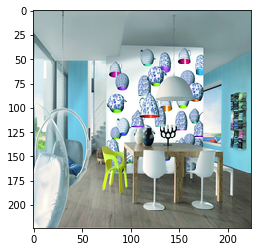

Predicted caption:
 chair table at  



In [97]:
generate_caption(os.path.join(IMAGE_DIR_REL, ('5f07cc69123be854' + '.jpg')))

80277f78e8600198
[('tennisracket', -14.447138), ('mobilephone', -13.840554), ('snake', -13.4959135), ('elephant', -13.280963), ('racket', -13.26486), ('tabletennisracket', -13.259279), ('snowboard', -13.125017), ('flute', -12.9655905), ('piano', -12.647453), ('ss', -12.552609), ('dolphin', -12.444629), ('ski', -12.349848), ('tennisball', -12.243149), ('monkey', -11.990782), ('surfboard', -11.918942), ('suitcase', -11.463012), ('backpack', -11.349617), ('hamster', -11.228925), ('taxi', -10.996211), (' ', -10.663031), ('chopsticks', -10.542203), ('football', -10.488324), ('rugbyball', -10.426208), ('knife', -10.3576355), ('wears', -10.149722), ('van', -10.050552), ('handbag', -10.041735), ('microphone', -9.696157), ('drum', -9.620757), ('horse', -9.321881), ('bed', -9.251923), ('under', -8.184377), ('motorcycle', -7.8695216), ('beer', -7.863003), ('camera', -7.5465646), ('of', -7.461263), ('hits', -7.3961997), ('bicycle', -7.3650913), ('fork', -7.339144), ('bench', -7.2692094), ('guitar'

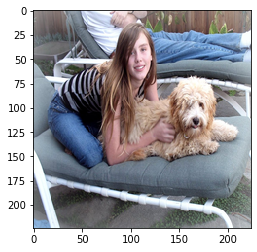

Predicted caption:
 dog chair on  

True captions:
['girl chair on', 'dog chair on', 'girl dog interacts_with']


In [170]:
try:
    generate_caption_train(np.random.choice(imageIDs_trainz))
except:
    pass

# Accuracy

In [99]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [100]:
def get_caption_train(image_path, max_tokens=4):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    global current
    current = current + 1
    print_progress(current, len(filenames_trainz))
#     # Load and resize the image.
#     image = load_image(image_path, size=img_size)
    
#     # Expand the 3-dim numpy array to 4-dim
#     # because the image-model expects a whole batch as input,
#     # so we give it a batch with just one image.
#     image_batch = np.expand_dims(image, axis=0)

#     # Process the image with the pre-trained image-model
#     # to get the transfer-values.
#     transfer_values = image_model_transfer.predict(image_batch)

    image_id, _ = os.path.splitext(os.path.basename(image_path))
    transfer_values = transfer_values_train[[np.where(imageIDs_trainz == image_id)[0][0]]]
    
    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    curr_words = 1
    
    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    
    #while token_int != token_end and count_tokens < max_tokens:
    #while curr_words < max_tokens-2:
    for i in range(4):
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
        #print((decoder_output))

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    
    # Print the predicted caption.
    return (output_text)

In [101]:
%%time
global current
current = 0
cache_path = os.path.join(DATA_OUTPUT_DIR,
                              f"trainz_{IMAGE_MODEL_NAME}_{DEPTH}_{LAYER_TYPE.lower()}_predictions.pkl")
trainz_predictions = cache(cache_path=cache_path,
                        fn=(lambda filenames: [get_caption_train(f).strip() for f in filenames]),
                        filenames=filenames_trainz)
len(trainz_predictions)

- Progress: 100.0% 57187/57187- Data saved to cache-file: D:\data\VRNet\trainz_mobilenetv2_1.00_224_9_lstm_predictions.pkl
Wall time: 1h 36min 16s


57187

In [102]:
len(set(trainz_predictions))

463

In [103]:
%%time
import pickle
precisions = {}
predictions = []

# model_name = get_model_name(params)
# cache_path = os.path.join(DATA_OUTPUT_DIR, os.path.join("predictions", 
#                                                         f"predictions_{get_model_name(params)}.pkl"))

# trainz_predictions = pickle.load(open(cache_path, 'rb'))
# predictions.append(trainz_predictions)
#     print(params)
precision = [prediction in actual 
             for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined)]
# precisions[model_name] = precision
print(f"{np.sum(precision)}/{len(precision)} {np.sum(precision)/len(precision)} :")

46342/51487 0.9000718628003185 :
Wall time: 48.9 ms


In [143]:
trainz_predictions
len(trainz_relationship_list_joined)

57187

In [137]:
correct = 0
for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined):
    if prediction in actual:
        correct = correct + 1

correct, len(trainz_relationship_list_joined), correct/len(trainz_relationship_list_joined)

(20292, 57187, 0.35483588927553467)

In [144]:
correct = 0
for prediction, actual in zip(trainz_predictions, trainz_relationship_list_joined):
    if prediction in actual:
        correct = correct + 1

correct, len(trainz_relationship_list_joined), correct/len(trainz_relationship_list_joined)

(21129, 57187, 0.3694720828160246)

***

***

## Donwload images containing relationship data

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [4]:
IMAGE_DIR_REL = r"D:\data\VRNet\imagenet_rel_subset"

In [5]:
def download_image(url, image_name, directory=""):
    import urllib
    import os
    urllib.request.urlretrieve(url, os.path.join(directory, image_name))

def download_images_from_df(dataframe, directory):
    import urllib
    import os
    current_files = os.listdir(directory)
    left_to_dl = dataframe[~dataframe.image_name.isin(current_files)]
    i = len(current_files)
    total = len(dataframe)
    print(f"Downloading {total} images")
    print(f"{i} images already downloaded")
    print(f"Downloading {len(left_to_dl)} remaining")
    
    for index, image_name, image_url in left_to_dl.itertuples():
        i = i + 1 
        print_progress(i, total)
        #if not image_name in current_files:# not os.path.isfile(os.path.join(directory, image_name)):
            #try:
        download_image(image_url, image_name, directory)
            #except: 
            #    pass# print(f"\nError downloading {image_name}")
    print(f"\nDownloaded total {i} images; available total {total}")

In [6]:
import pandas as pd

all_relationships_file = r"D:\data\open-images-2019-visual-relationship\challenge-2019-train-vrd.csv"
all_relationships = pd.read_csv(all_relationships_file)
# all_relationships.describe()
len(all_relationships)

374768

In [7]:
images_w_relationships = all_relationships.ImageID.unique()
len(images_w_relationships)

100522

In [8]:
url_indexes = pd.read_csv(r"D:\data\open-images-2019-visual-relationship\train-images-boxable.csv")
len(url_indexes)

1743042

In [9]:
images_w_relationships_names = [f + '.jpg' for f in images_w_relationships]
url_indexes_relationship = url_indexes[url_indexes.image_name.isin(images_w_relationships_names)]
len(url_indexes_relationship)

100521

In [ ]:
%%time
download_images_from_df(url_indexes_relationship, IMAGE_DIR_REL)

#### Prepare the training images 

In [64]:
filenames_trainz = [os.path.join(IMAGE_DIR_REL, f)
                for f in images_w_relationships_from_dir[:20000]]
len(filenames_trainz)

20000

In [65]:
%%time
transfer_values_train = process_images_train(filenames_trainz, "trainz")
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 20000 images in training-set ...
- Progress: 99.8% 19968/20000
- Data saved to cache-file: D:\data\VRNet\transfer_values_trainz.pkl
dtype: float16
shape: (20000, 4096)
Wall time: 33min 37s


In [61]:
%%time
# Check for faulty images.
removal_list = []
images_w_relationships_from_dir = [os.path.join(IMAGE_DIR_REL, f)
                for f in os.listdir(IMAGE_DIR_REL)]
i = 0
for fn in images_w_relationships_from_dir:
    i = i+1
    print_progress(i, len(images_w_relationships_from_dir))
    try: 
        img = Image.open(fn)
        img.close()
    except:
        removal_list.append(fn)
import pickle
removal_list_file = "to_remove.pkl"
with open(removal_list_file, 'wb') as f:
    pickle.dump(removal_list, f)

- Progress: 100.0% 62090/62090Wall time: 24min 51s


In [70]:
import pickle
with open("to_remove.pkl", 'rb') as f:
    raw = f.read()
removal_list = pickle.loads(raw)
len(removal_list)

80827

In [ ]:
removal_list[10]

In [63]:
for rem in removal_list:
    os.remove(rem)
for rem in removal_list:
    if os.path.isfile(rem):
        print(rem)

\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\


## Pr

In [1]:
import tarfile

tar = tarfile.open(r"D:\data\train-256.tar", "r:gz")


In [4]:
tar.list()

?rwxrwxr-x gsuite/gsuite          0 2019-05-07 05:20:59 train/ 
?rw-rw-r-- gsuite/gsuite      12325 2019-05-05 22:30:18 train/e1f9834934ef3e92.jpg 
?rw-rw-r-- gsuite/gsuite       9486 2019-05-05 22:30:18 train/e7b5158bdc657809.jpg 
?rw-rw-r-- gsuite/gsuite      12880 2019-05-05 22:30:18 train/30b0e36bccf2fd6d.jpg 
?rw-rw-r-- gsuite/gsuite      14792 2019-05-05 22:30:18 train/f75c85626db17a54.jpg 
?rw-rw-r-- gsuite/gsuite      11882 2019-05-05 22:30:18 train/720d4d205bdf190f.JPG 
?rw-rw-r-- gsuite/gsuite      21342 2019-05-05 22:30:18 train/4a187a0145a6400c.jpg 
?rw-rw-r-- gsuite/gsuite       7089 2019-05-05 22:30:18 train/ecb82e2f8b73847d.jpg 
?rw-rw-r-- gsuite/gsuite      14971 2019-05-05 22:30:18 train/1d32395d06e3872f.jpg 
?rw-rw-r-- gsuite/gsuite      12744 2019-05-05 22:30:18 train/bd0ca91b207958ee.jpg 
?rw-rw-r-- gsuite/gsuite       6429 2019-05-05 22:30:18 train/46b78b76a4455dfa.jpg 
?rw-rw-r-- gsuite/gsuite       9527 2019-05-05 22:30:18 train/3531fe9a0c2429da.jpg 
?rw-rw-r-- g

KeyboardInterrupt: 

In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s


In [2]:
%%time
tar.extractall(path=r"D:\data\train-256")
tar.close()

Wall time: 1d 23h 23min 38s
